In [28]:
#from itertools import product
#from matplotlib.collections import LineCollection
#import statsmodels.formula.api as smf
#from scipy.stats import chisquare
import numpy as np
from scipy.stats import linregress
import scipy
from matplotlib import pyplot as plt
from IPython.display import Image, display, HTML
import pandas as pd
import datetime as datetime
movies_df = pd.read_csv('movies_for_analysis.csv',encoding='utf-8',index_col='imdb_id')
#movies.shape
#movies.sample(1)
#x.columns
movies_df['released'] = pd.to_datetime(movies_df['released'])
print('Dataset loaded')

Dataset loaded


In [29]:
display(HTML('<h1>Number of movies</h1>'))

print('Total number of movies: {0:,.0f}'.format(len(movies_df)))
print('Movies with Bechdel test results: {0:,.0f}'.format(len(movies_df[~pd.isnull(movies_df['bechdel_rating'])])))
print('Movies with box office receipt data: {0:,.0f}'.format(len(movies_df[~pd.isnull(movies_df['boxoffice_adj'])])))
print('Movies with profit data: {0:,.0f}'.format(len(movies_df[~pd.isnull(movies_df['profit_adj'])])))


Total number of movies: 7,266
Movies with Bechdel test results: 7,266
Movies with box office receipt data: 4,594
Movies with profit data: 2,748


In [30]:
bechdel_result_table = pd.DataFrame()
bechdel_result_table['nMovies'] = movies_df.groupby('bechdel_rating').size()
bechdel_result_table['result'] = ''
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 0, 'Fewer than two women',bechdel_result_table['result'])
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 1, 'Women don\'t talk',bechdel_result_table['result'])
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 2, 'Women talk about a man',bechdel_result_table['result'])
bechdel_result_table['result'] = np.where(bechdel_result_table.index == 3, 'Passes Bechdel test',bechdel_result_table['result'])

bechdel_result_table['percentage'] = 100 * (bechdel_result_table['nMovies'] / len(movies_df))
#bechdel_result_table = bechdel_result_table.set_index('result')
#bechdel_result_table = bechdel_result_table.reset_index()
bechdel_result_table[['result','nMovies','percentage']].style.format({'result': '{:10}', 'nMovies': '{:,.0f}', 'percentage': '{0:.0f}%'})

,result,nMovies,percentage
bechdel_rating,,,
0,Fewer than two women,751,10%
1,Women don't talk,"1,607",22%
2,Women talk about a man,733,10%
3,Passes Bechdel test,"4,175",57%


In [31]:
#movies_df.sample(1).transpose()
movies_df['yearbin'] = ''
movies_df['yearbin'] = np.where((movies_df['bechdel_year'] < 1950), ' Before 1950', movies_df['bechdel_year'])
movies_df['yearbin'] = np.where(((movies_df['bechdel_year'] >= 1950) & (movies_df['bechdel_year'] < 1960)), '1950s', movies_df['yearbin'])
movies_df['yearbin'] = np.where(((movies_df['bechdel_year'] >= 1960) & (movies_df['bechdel_year'] < 1970)), '1960s', movies_df['yearbin'])
movies_df['yearbin'] = np.where(((movies_df['bechdel_year'] >= 1970) & (movies_df['bechdel_year'] < 1980)), '1970s', movies_df['yearbin'])
movies_df['yearbin'] = np.where(((movies_df['bechdel_year'] >= 1980) & (movies_df['bechdel_year'] < 1990)), '1980s', movies_df['yearbin'])
movies_df['yearbin'] = np.where(((movies_df['bechdel_year'] >= 1990) & (movies_df['bechdel_year'] < 2000)), '1990s', movies_df['yearbin'])
movies_df['yearbin'] = np.where(((movies_df['bechdel_year'] >= 2000) & (movies_df['bechdel_year'] < 2010)), '2000s', movies_df['yearbin'])
movies_df['yearbin'] = np.where(((movies_df['bechdel_year'] >= 2010)), '2010s', movies_df['yearbin'])

movies_df.groupby('yearbin').size()

yearbin
 Before 1950     541
1950s            240
1960s            303
1970s            324
1980s            545
1990s            958
2000s           2033
2010s           2322
dtype: int64

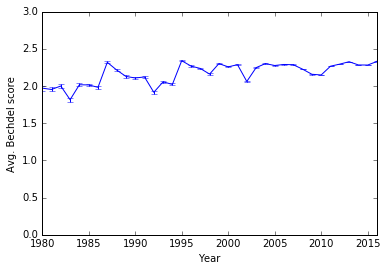

In [32]:
# Do some fancy re-indexing and groupby operations to get average scores and number of movies
#import statsmodels.api as sm 
avg_bechdel = movies_df.groupby('bechdel_year')['bechdel_rating'].agg(np.mean)
stdevm_bechdel = movies_df.groupby('bechdel_year')['bechdel_rating'].agg(np.std) / movies_df.groupby('bechdel_year')['bechdel_rating'].size()

x = avg_bechdel.index
y = avg_bechdel.get_values()
yerrvals = stdevm_bechdel.get_values()
plt.errorbar(x,y,yerr=yerrvals)

#plt.autoscale()
plt.xlim((1980,2016))
plt.xlabel('Year')
plt.ylabel('Avg. Bechdel score')

plt.show()
#stdevm_bechdel

We can also estimate a statistical model to forecast future changes in the average Bechdel score over time. We observe a general upward trend in movies passing more of the Bechdel test and can try to extrapolate this going forward.

Regression model: Bechdel test scores have increased by 0.010 each year since 1969, with r^2 = 0.53.


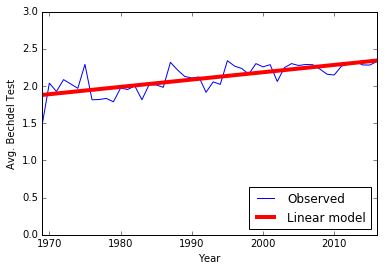

In [34]:
#import statsmodels.formula.api as smf
#from scipy import ols
firstyear = 1969 # first year after the Hays code ended
lastyear = 2016 # last full year in dataset
avg_bechdel = movies_df.groupby('bechdel_year')['bechdel_rating'].agg(np.mean)
avg_bechdel.index.name = 'date'
avg_bechdel.name = 'bechdel'
avg_bechdel = avg_bechdel[(avg_bechdel.index >= firstyear) & (avg_bechdel.index <= lastyear)]
avg_bechdel = avg_bechdel.reset_index()
avg_bechdel

[slope,intercept,rvalue,pvalue,stderr] = linregress(avg_bechdel['date'],avg_bechdel['bechdel'])
#print(slope,intercept,rvalue)
r_squared = rvalue ** 2

print('Regression model: Bechdel test scores have increased by {0:.3f} each year since {1:.0f}, with r^2 = {2:.2f}.'.format(slope,firstyear,r_squared))
predicted = pd.DataFrame({"date": np.linspace(start=1969.,stop=2016.,num=48)})
predicted['bechdel'] = slope*predicted['date'] + intercept

# Plot the observed data
plt.plot(avg_bechdel['date'],avg_bechdel['bechdel'],c='b',label='Observed')

# Plot the predictions from the model
plt.plot(predicted['date'],predicted['bechdel'],c='r',label='Linear model',lw=4)
plt.legend(loc='lower right')
plt.ylim((0,3))
plt.xlim((1969,2016))
plt.xlabel('Year')
plt.ylabel('Avg. Bechdel Test')
plt.show()

As I discussed above, the claim that budgets for Bechdel-passing movies is relatively uncontroversial and given the description of the data in the article, should be easy to reproduce. Visualizing the distribution of the data, there are no strong differences that jump out but if you squint hard enough, you can make out a negative trend: movies passing the Bechdel test have lower budgets.

You'll notice each cloud of points around 0, 1, 2, and 3. These are simply "jittered" by adding a bit of normally-distributed errors to the plots (but not the underlying data we're estimating) to show the frequency of datapoints without them all sitting on top of each other.

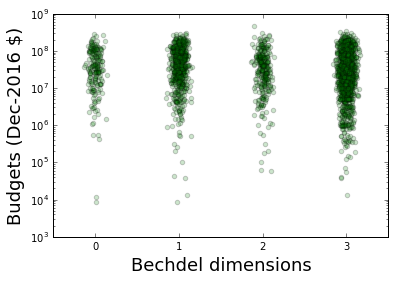

In [37]:
x = movies_df['bechdel_rating'].apply(lambda x:float(x)+np.random.normal(0, 0.05))
y = movies_df['budget_adj']

# Plot with an alpha so the overlaps reveal something about relative density
plt.scatter(x,y,alpha=.2,label='Data',c='g')
plt.ylabel('Budgets (Dec-2016 $)',fontsize=18)
plt.xlabel('Bechdel dimensions',fontsize=18)
plt.xticks(np.arange(0,4))
plt.yscale('log')
plt.grid(False,which='minor')
#plt.ylim((2e0,1e10))

We can also visualize the median budgets with a bar chart to see that movies featuring two women who don't talk to each other appear to have much larger budgets than the rest. Movies that pass the Bechdel test also appear to have slightly smaller budgets than movies that don't pass.

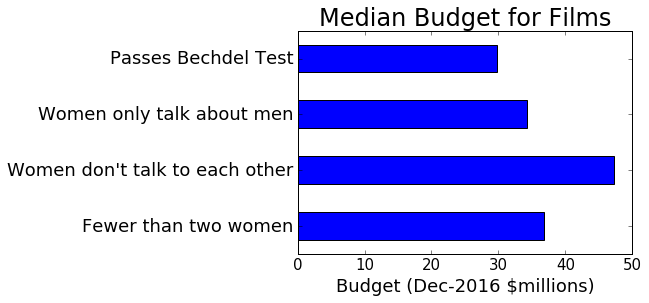

In [51]:
movies_df['budget_adj'].groupby(movies_df['bechdel_rating']).agg(np.median).plot(kind='barh')
#plt.xticks(range(0,7e7,1e7),range(0,70,10),fontsize=15)
#plt.xticks(range(0e7,7e7,1e7),range(0,70,10),fontsize=15)
plt.xticks(range(0,60000000,10000000),range(0,60,10),fontsize=15)
plt.yticks(plt.yticks()[0],["Fewer than two women",
                             "Women don't talk to each other",
                             'Women only talk about men',
                             'Passes Bechdel Test'
                             ],fontsize=18)
plt.xlabel('Budget (Dec-2016 $millions)',fontsize=18)
plt.title('Median Budget for Films',fontsize=24)
plt.ylabel('')
plt.show()

In [55]:
median_budget = movies_df['budget_adj'].groupby(movies_df['bechdel_rating']).agg(np.median)
median_budget.index.name = 'bechdel_rating'
median_budget.name = 'median_budget'
median_budget = median_budget.reset_index()
#[slope,intercept,rvalue,pvalue,stderr] = 
linregress(median_budget['bechdel_rating'],median_budget['median_budget'])

#print('Regression model: Bechdel test scores have increased by {0:.3f} each year since {1:.0f}, with r^2 = {2:.2f}.'.format(slope,firstyear,r_squared))


#avg_bechdel = avg_bechdel[(avg_bechdel.index >= firstyear) & (avg_bechdel.index <= lastyear)]
#avg_bechdel = avg_bechdel.reset_index()
#avg_bechdel

#[slope,intercept,rvalue,pvalue,stderr] = linregress(avg_bechdel['date'],avg_bechdel['bechdel'])
#print(slope,intercept,rvalue)
#r_squared = rvalue ** 2

#print('Regression model: Bechdel test scores have increased by {0:.3f} each year since {1:.0f}, with r^2 = {2:.2f}.'.format(slope,firstyear,r_squared))
#predicted = pd.DataFrame({"date": np.linspace(start=1969.,stop=2016.,num=48)})
#predicted['bechdel'] = slope*predicted['date'] + intercept

#avg_bechdel = avg_bechdel[(avg_bechdel.index >= firstyear) & (avg_bechdel.index <= lastyear)]
#avg_bechdel = avg_bechdel.reset_index()
#avg_bechdel


LinregressResult(slope=-3366699.0021028318, intercept=42061634.657655321, rvalue=-0.58907101382827975, pvalue=0.41092898617172025, stderr=3265702.9649782362)